In [2]:
import numpy as np
import glob
import sys
import scipy.io as sio
import datetime
import os
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.facecolor']='white'
# from ml_detection.ml_detection import detect_ml
from netCDF4 import Dataset
import copy

In [5]:
nc = Dataset('/ltenas8/campaigns/ICEGENESIS_2021/AERIS_EPFL/MXPol/PPI90/ICE-GENESIS_LES-EPLATURES_EPFL_MXPol-PPI_20210127-153745_L0_V1.nc')

In [6]:
specH = nc.variables['sPowH'][:]
specV = nc.variables['sPowV'][:]
specCVR = nc.variables['sCC_real'][:]
specCVI = nc.variables['sCC_imag'][:]
svel = nc.variables['sVel'][:]
r = nc.variables['range'][:]
t = nc.variables['time'][:]

Text(0.5, 0, 'Doppler vel (m/s)')

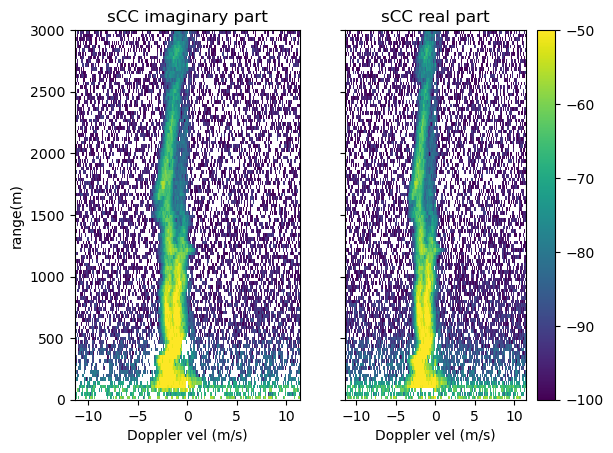

In [11]:
fig, ax = plt.subplots(1,2,sharex = True, sharey = True)
ax[0].pcolormesh(svel,r,10*np.log10(specCVI[15,:,:]),vmin=-100,vmax=-50)
im = ax[1].pcolormesh(svel,r,10*np.log10(specCVR[15,:,:]),vmin=-100,vmax=-50)
plt.colorbar(im)
plt.ylim(0,3000)
ax[0].set_title('sCC imaginary part')
ax[1].set_title('sCC real part')
ax[0].set_ylabel('range(m)')
ax[0].set_xlabel('Doppler vel (m/s)')
ax[1].set_xlabel('Doppler vel (m/s)')

In [13]:
def clutter_filter(power, vel_array, cfw):
    """
        PURPOSE
            Function to remove clutter through an interpolation of the spectrum around 0 m/s
        
        INPUTS
            power: array of measured powers with "n_rg" lines and "n_vel_bins" columns 
            vel_array: array of Doppler velocity bins
            cfw: clutter filter width (width of the interval where clutter is suspected to affect the spectra)
            
        OUTPUT
            power_filt: power array after clutter filtering
    """
    if power.ndim == 3:
        filt = np.where((vel_array>=-cfw) & (vel_array<=cfw))[0]
        power_filt = power.copy()
        power_filt[:,:,filt] = 10**(np.log10(power_filt[:,:,filt[0]-1])[:,:,None] + 
                                    (np.log10(power_filt[:,:,filt[-1]+1])-np.log10(power_filt[:,:,filt[0]-1]))[:,:,None] / 
                                    (filt[-1]-filt[0]+2)*(filt[None,None,:]-filt[0]+1))
    elif power.ndim == 2:
        filt = np.where((vel_array>=-cfw) & (vel_array<=cfw))[0]
        power_filt = power.copy()
        power_filt[:,filt] = 10**(np.log10(power_filt[:,filt[0]-1])[:,None] + 
                                  (np.log10(power_filt[:,filt[-1]+1])-np.log10(power_filt[:,filt[0]-1]))[:,None] / 
                                  (filt[-1]-filt[0]+2)*(filt[None,:]-filt[0]+1))
    return power_filt


def get_noise_vectorized(power,fft_avg, calc_stdv = True):
    '''
        PURPOSE
            Vectorized function to get the noise level, same as above
            with mrr = False but vectorized over all radials
            Refers to Hildebrand method of Noise calculation. ("Objective determination of noise level..." PH Hildebrand, 1974)
            
        INPUTS
            power: array of measured powers with "n_rg" lines and "n_vel_bins" columns
            fft_avg : number of non-coherent averages
            calc_stdv : if true the stdev of the noise estimates will be returned as well
        
        OUTPUTS
            lnoise : estimated noise level

    '''
    sorted_spectrum = np.sort(power, axis=1)
    npts_min = int(len(power[0]) / 20)

    lnoise = np.zeros((len(power))) + np.nan
    
    nsamples = np.arange(len(power[0]))+1
    
    # Compute partial averages and variances
    mean_rolling = np.cumsum(sorted_spectrum, axis=1)/nsamples 
    mean2_rolling = np.cumsum(sorted_spectrum**2, axis=1)/nsamples
    var_rolling = mean2_rolling - mean_rolling**2
    
    condi = var_rolling * fft_avg <= mean_rolling**2.
        
    # Get occurence of first non white noise gate
    first_notwn = np.argmin(condi, axis=1) - 1
    # first_notwn[~np.any(condi == 0)] = 0 

    condi_npts = (first_notwn>=0) & (first_notwn < npts_min)
    
    lnoise = mean_rolling[np.arange(len(first_notwn)), first_notwn]
    lnoise[condi_npts] = mean_rolling[condi_npts, npts_min - 1]   
    
    if calc_stdv:
        stdv = np.sqrt(var_rolling[np.arange(len(first_notwn)),first_notwn])
        stdv[condi_npts] = np.sqrt(var_rolling[condi_npts, npts_min - 1]) 
        
    if calc_stdv:
        return lnoise, stdv
    else:
        return lnoise


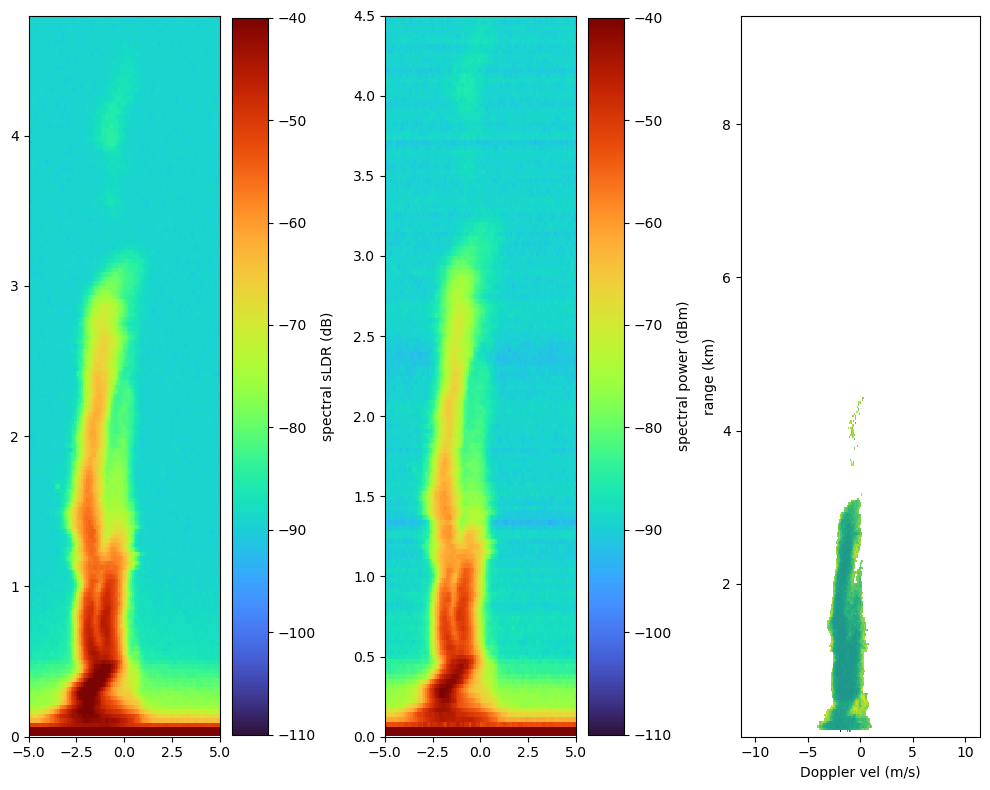

In [29]:
# Initialize the containers
spec_cx = np.empty((len(t),len(r)))

# Implement the clutter filtering
specH = clutter_filter(specH,svel,0.1)
specV = clutter_filter(specV,svel,0.1)
specCVR = clutter_filter(specCVR,svel,0.1)
specCVI = clutter_filter(specCVI,svel,0.1)

# Define some useful variables
mdv = np.sum(specH*svel,axis=2)/np.sum(specH,axis=2)     # mean Doppler velocity profiles at each time step of the PPI
idv = np.sum(specH*np.arange(0,len(svel)),axis=2)/np.sum(specH,axis=2) # index of the mean Doppler velocity 
idvmean = idv.mean(axis=0) # mean of idv over the full PPI
specHshifted = copy.deepcopy(specH)
specCX = specHshifted*0.
specCXshifted = specHshifted*0.

"""
This is a loop through all time steps of the 90deg-PPI to average the spectra.
To account for possible antenna misalignment, the following adjustment is made: 
- at each time step, we compare the mean Doppler velocity (MDV) profile to the average MDV on the full PPI => this gives us a "shift"
- we correct the spectrum for this shift
- this ensures that all the spectra during the PPI have the same MDV profile
- this in turn improves the quality when computing the average of all spectra (less broadening)
"""

for nt in range(len(t)):    
    
    # lnoise,stdv = get_noise_vectorized(specH[nt,:,:],2)
    # lnoiseV,stdvV = get_noise_vectorized(specV[nt,:,:],2)
    # lnoiseCV,stdvCV = get_noise_vectorized(specCVR[nt,:,:],2)
    sH = specH[nt,:,:].copy()
    sV = specV[nt,:,:].copy()
    sCVR = specCVR[nt,:,:].copy()
    
    i_0 = (sH < 0) |(sV < 0)
    sV[i_0] = 0
    sH[i_0] = 0
    sCVR[i_0] = 0

    # spec_cx[nt,:] = np.nansum((sH+sV-2*sCVR),axis=1)
    specCX[nt,:,:] = (sH+sV-2*sCVR)
    shift = np.int64(np.round(idvmean-idv[nt,:]))
    for nr in range(len(r)):
        s = -shift[nr]
        if s!=0:
            specHshifted[nt,nr,:-s] = specH[nt,nr,s:]
            specHshifted[nt,nr,-s:] = specH[nt,nr,:s]
            specCXshifted[nt,nr,:-s] = specCX[nt,nr,s:]
            specCXshifted[nt,nr,-s:] = specCX[nt,nr,:s]
            
average_spec = np.mean(specHshifted,axis=0)
average_spec_cx = np.mean(specCXshifted,axis=0)

lnoise,stdv = get_noise_vectorized(average_spec,2)

fig,axs=plt.subplots(1,2,figsize=(8,8))
#     plt.

im0 = axs[0].pcolormesh(svel,r/1000,10*np.log10(average_spec),vmin=-110,vmax=-40,cmap='turbo')
im1 = axs[1].pcolormesh(svel,r/1000,10*np.log10(average_spec_cx),vmin=-110,vmax=-40,cmap='turbo')
plt.colorbar(im1,ax=axs[1],label='spectral power (dBm)')
axs[0].set_ylim(0,4.8)
axs[0].set_xlim(-5,5)
axs[1].set_ylim(0,4.5)
axs[1].set_xlim(-5,5)
plt.ylabel('range (km)')
plt.xlabel('Doppler vel (m/s)')
fig.tight_layout()